In [56]:
#The goal is to understand the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "C:/Users/sweta/anaconda_projects/non-trivial/saved_models/sar2opticalmod/pix2pix_gen_ckpt_21.pt"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
#----understand state dict----
print(type(checkpoint))
#-----view all parameter keys-----
for k in checkpoint.keys():
    print(k)
#----layer shapes and names ----
for name, param in checkpoint.items():
    print(f"{name}: {tuple(param.shape)}")
#---count and summarize layers---
from collections import Counter
layer_types = [k.split('.')[-1] for k in checkpoint.keys()]
print(Counter(layer_types))

<class 'collections.OrderedDict'>
encoder.enc1.conv_block.0.weight
encoder.enc1.conv_block.0.bias
encoder.enc2.conv_block.0.weight
encoder.enc2.conv_block.1.weight
encoder.enc2.conv_block.1.bias
encoder.enc2.conv_block.1.running_mean
encoder.enc2.conv_block.1.running_var
encoder.enc2.conv_block.1.num_batches_tracked
encoder.enc3.conv_block.0.weight
encoder.enc3.conv_block.1.weight
encoder.enc3.conv_block.1.bias
encoder.enc3.conv_block.1.running_mean
encoder.enc3.conv_block.1.running_var
encoder.enc3.conv_block.1.num_batches_tracked
encoder.enc4.conv_block.0.weight
encoder.enc4.conv_block.1.weight
encoder.enc4.conv_block.1.bias
encoder.enc4.conv_block.1.running_mean
encoder.enc4.conv_block.1.running_var
encoder.enc4.conv_block.1.num_batches_tracked
encoder.enc5.conv_block.0.weight
encoder.enc5.conv_block.1.weight
encoder.enc5.conv_block.1.bias
encoder.enc5.conv_block.1.running_mean
encoder.enc5.conv_block.1.running_var
encoder.enc5.conv_block.1.num_batches_tracked
encoder.enc6.conv_bloc

C:\Users\sweta\AppData\Local\Temp\ipykernel_20292\1482718133.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')

In [43]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0, transpose=False):
        super().__init__()
        layers = []
        if transpose:
            layers.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
            )
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        else:
            layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
            )
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.conv_block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv_block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()
        
        # Encoder blocks (downsampling)
        self.encoder = nn.ModuleDict({
            'enc1': ConvBlock(in_channels, 64, normalize=False),
            'enc2': ConvBlock(64, 128),
            'enc3': ConvBlock(128, 256),
            'enc4': ConvBlock(256, 512),
            'enc5': ConvBlock(512, 512),
            'enc6': ConvBlock(512, 512),
            'enc7': ConvBlock(512, 512),
            'enc8': ConvBlock(512, 512, normalize=False),
        })
        
        # Decoder blocks (upsampling)
        self.decoder = nn.ModuleDict({
            'dec1': ConvBlock(512, 512, dropout=0.5, transpose=True),
            'dec2': ConvBlock(1024, 512, dropout=0.5, transpose=True),
            'dec3': ConvBlock(1024, 512, dropout=0.5, transpose=True),
            'dec4': ConvBlock(1024, 512, transpose=True),
            'dec5': ConvBlock(1024, 256, transpose=True),
            'dec6': ConvBlock(512, 128, transpose=True),
            'dec7': ConvBlock(256, 64, transpose=True),
            'dec8': ConvBlock(128, 64, transpose=True),
        })

        # The 'head' conv layer with bias=True
        self.head = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Encoder forward pass with skip connections
        enc_outputs = []
        out = x
        for i in range(1, 9):
            out = self.encoder[f'enc{i}'](out)
            enc_outputs.append(out)
        
        # Decoder forward pass with concatenation of skip connections
        for i in range(1, 9):
            dec_input = out
            if i > 1:
                # concatenate skip connection from corresponding encoder output
                skip = enc_outputs[-(i)]
                dec_input = torch.cat([out, skip], dim=1)
            out = self.decoder[f'dec{i}'](dec_input)
        
        out = self.head(out)
        return out

In [45]:
'''ckpt = torch.load(
    "C:/Users/sweta/anaconda_projects/non-trivial/saved_models/sar2opticalmod/pix2pix_gen_ckpt_21.pt",
    map_location=torch.device('cpu')
)
print(type(ckpt))'''

'ckpt = torch.load(\n    "C:/Users/sweta/anaconda_projects/non-trivial/saved_models/sar2opticalmod/pix2pix_gen_ckpt_21.pt",\n    map_location=torch.device(\'cpu\')\n)\nprint(type(ckpt))'

In [64]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0, transpose=False, use_batchnorm=True):
        super().__init__()
        layers = []
        if transpose:
            # ConvTranspose2d with bias=False if BatchNorm used
            layers.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not use_batchnorm)
            )
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        else:
            # Conv2d with bias=False if BatchNorm used
            layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not use_batchnorm)
            )
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        
        self.encoder = nn.ModuleDict({
            'enc1': ConvBlock(in_channels, 64, use_batchnorm=False),  # No BatchNorm on first layer
            'enc2': ConvBlock(64, 128),
            'enc3': ConvBlock(128, 256),
            'enc4': ConvBlock(256, 512),
            'enc5': ConvBlock(512, 512),
            'enc6': ConvBlock(512, 512),
            'enc7': ConvBlock(512, 512),
            'enc8': ConvBlock(512, 512),
        })

        self.decoder = nn.ModuleDict({
            'dec1': ConvBlock(512, 512, dropout=0.5, transpose=True),
            'dec2': ConvBlock(1024, 512, dropout=0.5, transpose=True),
            'dec3': ConvBlock(1024, 512, dropout=0.5, transpose=True),
            'dec4': ConvBlock(1024, 512, transpose=True),
            'dec5': ConvBlock(1024, 256, transpose=True),
            'dec6': ConvBlock(512, 128, transpose=True),
            'dec7': ConvBlock(256, 64, transpose=True),
            'dec8': ConvBlock(128, 64, transpose=True),
        })

        self.head = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=True),  # final conv has bias=True
            nn.Tanh()
        )

    def forward(self, x):
        enc_outputs = []
        out = x
        for i in range(1, 9):
            out = self.encoder[f'enc{i}'](out)
            enc_outputs.append(out)

        for i in range(1, 9):
            dec_input = out
            if i > 1:
                skip = enc_outputs[-(i)]
                dec_input = torch.cat([out, skip], dim=1)
            out = self.decoder[f'dec{i}'](dec_input)

        out = self.head(out)
        return out


model = UNet(in_channels=3, out_channels=3)
model_keys = set(model.state_dict().keys())
checkpoint_keys = set(checkpoint.keys())

missing_keys = model_keys - checkpoint_keys
unexpected_keys = checkpoint_keys - model_keys

print(f"Keys expected by model but missing in checkpoint:\n{missing_keys}\n")
print(f"Keys in checkpoint but not expected by model:\n{unexpected_keys}\n")

#reload model
model = UNet(in_channels=3, out_channels=3).to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)  # ✅ should now load cleanly


Keys expected by model but missing in checkpoint:
set()

Keys in checkpoint but not expected by model:
set()



C:\Users\sweta\AppData\Local\Temp\ipykernel_20292\1892134895.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

<All keys matched successfully>

Loading checkpoint...
Model loaded and set to evaluation mode.


C:\Users\sweta\AppData\Local\Temp\ipykernel_20292\960447306.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Input tensor shape: torch.Size([1, 3, 256, 256])
Output tensor shape: torch.Size([1, 3, 256, 256])
Generated image saved to outputs\generated_optical.png


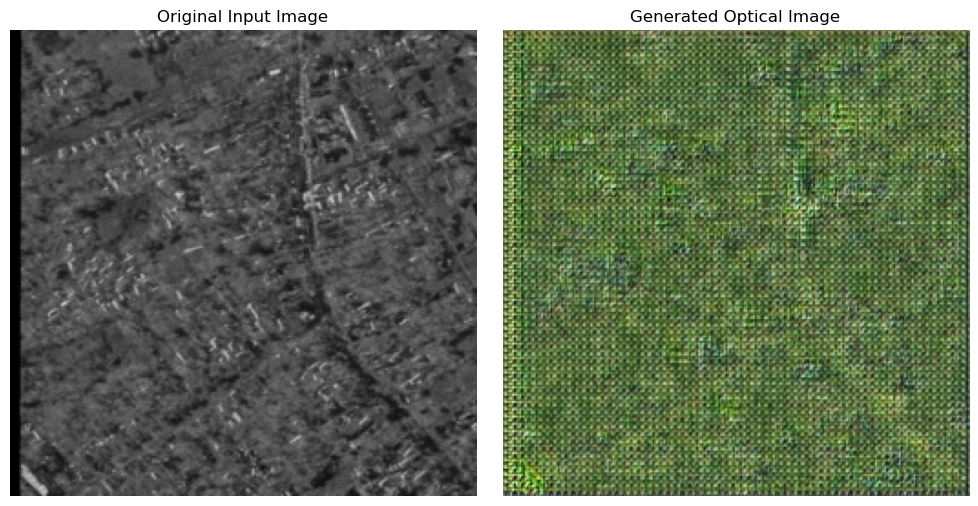

In [68]:
import torch
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import matplotlib.pyplot as plt

# 1. Setup device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "C:/Users/sweta/anaconda_projects/non-trivial/saved_models/sar2opticalmod/pix2pix_gen_ckpt_21.pt"
input_image_path = r"C:\Users\sweta\Downloads\post-event\post-event\haiti-earthquake_00000004_post_disaster.tif"
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# 2. Define UNet model (paste your class here if not imported)
model = UNet(in_channels=3, out_channels=3).to(device)

# 3. Load checkpoint
print("Loading checkpoint...")
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("Model loaded and set to evaluation mode.")

# 4. Define transform for input (normalize RGB to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 5. Load and preprocess image
original_img = Image.open(input_image_path).convert("RGB")  # Keep original
input_tensor = transform(original_img).unsqueeze(0).to(device)
print(f"Input tensor shape: {input_tensor.shape}")

# 6. Inference
with torch.no_grad():
    output = model(input_tensor)
print(f"Output tensor shape: {output.shape}")

# 7. Save generated image
output = (output + 1) / 2  # [-1,1] → [0,1]
output_path = os.path.join(output_dir, "generated_optical.png")
save_image(output, output_path)
print(f"Generated image saved to {output_path}")

# 8. Visualize input vs. output side by side
# Convert tensors to displayable format
output_np = output.squeeze().cpu().permute(1, 2, 0).numpy()
original_resized = transforms.Resize((256, 256))(original_img)
original_np = transforms.ToTensor()(original_resized).permute(1, 2, 0).numpy()

# Plot side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_np)
plt.title("Original Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_np)
plt.title("Generated Optical Image")
plt.axis('off')

plt.tight_layout()
plt.show()